In [1]:
import numpy as np
import torch
import ot
import matplotlib.pylab as pl
import ot.plot

In [2]:
import sys
sys.path.append('../code/')
from generate_data import make_data
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn
from utils import kernel

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [4]:
n,d=50,2
np.random.seed(0)
X,Y=make_data('gaussians',n,d)
C=ot.dist(X,Y)

In [5]:
a=torch.ones((n,))/n
b=torch.ones((n,))/n
#b=torch.randint(1, 5, (n,),dtype=float)
#b/=torch.sum(b)
#b=b.float()

In [6]:
import torch
import ot
from scipy.special import lambertw
    

def sinkhorn(a,b,C,lam=50,eps=1,numiter=500,lam2=None,pen=None,thr=1e-5,
             Cx=None,Cy=None,lam3=None,eps2=None,numiter2=1,innerplan=False,
             Kx=None,Ky=None,lr=1e-3):
    u_old=a
    v_old=b
    u=a
    G=torch.exp(-C/eps)
    uy=G.T@u
    ux=None
    if lam2 is None:
        lam2=lam
    if lam3 is None:
        lam3=lam
    if eps2 is None:
        eps2=eps
    if pen =="sinkhorn" or pen=="UOT_sinkhorn" or pen=="sinkhorn_1iter" or pen=="UOT_sinkhorn_1iter":
        Gx=torch.exp(-Cx/eps2)
        Gy=torch.exp(-Cy/eps2)
    for i in range(numiter):
        if pen is None:
            prox=b
        elif pen=="kl":
            prox=prox_KL(G.T@u,b,lam2,eps)
        elif pen=="l2":
            prox=prox_l2(G.T@u,b,lam2)
        elif pen=="MMD":
            prox=prox_MMD(G.T@u,b,Ky,lam2,eps,uy,numiter2,lr)
            uy=prox.clone()
        elif pen=="sinkhorn":
            uy,vy=prox_sinkhorn(G.T@u,b,Gy,lam2/eps,eps2,numiter2,uy)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1)) 
            prox=torch.sum(Qy,axis=1)
        elif pen=="sinkhorn_1iter":
            uy,vy=prox_sinkhorn_1iter(G.T@u,b,Gy,lam2/eps,eps2,numiter2,uy)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1)) 
            prox=torch.sum(Qy,axis=1)
        elif pen=="UOT_sinkhorn":
            uy,vy=prox_UOT_sinkhorn(G.T@u,b,Gy,lam2/eps,eps2,numiter2,lam3,uy)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1))
            prox=torch.sum(Qy,axis=1)
        elif pen=="UOT_sinkhorn_1iter":
            uy,vy=prox_UOT_sinkhorn_1iter(G.T@u,b,Gy,lam2/eps,eps2,numiter2,lam3,uy)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1))
            prox=torch.sum(Qy,axis=1)
                                   
        v=prox/(G.T@u)
        
        if pen is None:
            prox=a
        elif pen=="kl":
            prox=prox_KL(G@v,a,lam,eps)
        elif pen=="l2":
            prox=prox_l2(G@v,a,lam)
        if pen=="MMD":
            prox=prox_MMD(G@v,a,Kx,lam,eps,ux,numiter2,lr)
            ux=prox.clone()
        elif pen=="sinkhorn":
            ux,vx=prox_sinkhorn(G@v,a,Gx,lam/eps,eps2,numiter2,ux)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1)) 
            prox=torch.sum(Qx,axis=1)
        elif pen=="sinkhorn_1iter":
            ux,vx=prox_sinkhorn_1iter(G@v,a,Gx,lam/eps,eps2,numiter2,ux)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1)) 
            prox=torch.sum(Qx,axis=1)
        elif pen=="UOT_sinkhorn":
            ux,vx=prox_UOT_sinkhorn(G@v,a,Gx,lam/eps,eps2,numiter2,lam3,ux)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1))
            prox=torch.sum(Qx,axis=1) 
        elif pen=="UOT_sinkhorn_1iter":
            ux,vx=prox_UOT_sinkhorn_1iter(G@v,a,Gx,lam/eps,eps2,numiter2,lam3,ux)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1))
            prox=torch.sum(Qx,axis=1) 
  
        u=prox/(G@v)
    
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<thr:
                if innerplan:
                    return u,v,G,Qx,Qy
                else:
                    return u,v,G
        else:
            u_old=u
            v_old=v
    if innerplan:
        return u,v,G,Qx,Qy
    else:
        return u,v,G


      
def prox_KL(Gu,b,lam,eps):
    gam1=lam/(eps+lam)
    gam2=eps/(eps+lam)
    return (Gu**gam2)*(b**gam1)
    
def prox_l2(Gv,b,lam):
    return (torch.real(lambertw(lam*Gv*torch.exp(lam*b), k=0, tol=1e-8))/lam).float()

def prox_MMD(Gv,b,K,lam,eps,u_warm=None,numiter=100,lr=1e-3):
    if u_warm is None:# warmstart
        u_warm=Gv
    u,loss_l=logGD_MMDpen(Gv,b,K,lam,eps,u_warm,numiter,lr)
    return u

def MMDpen(u,Gv,b,K,lam,eps):
    return eps*(torch.sum(u*torch.log(u/Gv)-u+Gv))+lam*(b@K@b+u@K@u-2*b@K@u)


def loggrad_MMD(f,Gv,b,K,lam,eps):
    return eps*(f-torch.log(Gv))+2*lam*K@(torch.exp(f)-b)
  
def logGD_MMDpen(Gv,b,K,lam,eps,u_warm,numiter=100,lr=1e-2):
    f=torch.log(u_warm)
    loss_l=[]
    for i in range(numiter):
        f_next=f-lr*loggrad_MMD(f,Gv,b,K,lam,eps)
        if torch.norm(f_next-f)<1e-2:
            #print("i",i)
            return torch.exp(f),loss_l
        f=f_next.clone()
        loss_l+=[MMDpen(torch.exp(f),Gv,b,K,lam,eps)]
    #f_next=f-lr*loggrad_MMD(f,Gv,b,K,lam,eps)
    #print(torch.norm(f_next-f))
    return torch.exp(f),loss_l
        
def prox_sinkhorn(Gv,b,G,lam,eps2,numiter,u): 
    if u is None:# warmstart
        u=Gv
    gamma=lam/(eps2+lam)
    u_old=u
    v_old=b
    for i in range(numiter):
        v=b/(G@u)
        u=(Gv/(G@v))**gamma
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<1e-5:
            v=b/(G@u)
            return u,v
        else:
            u_old=u
            v_old=v
    v=b/(G@u)
    return u,v
    
def prox_UOT_sinkhorn(Gv,b,G,lam1,eps2,numiter,lam2,u):
    if u is None:
        u=Gv
    gamma1=lam1/(eps2+lam1)
    gamma2=lam2/(eps2+lam2)
    u_old=u
    v_old=b
    for i in range(numiter):
        v=(b/(G@u))**gamma2
        u=(Gv/(G@v))**gamma1
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<1e-5:
            v=b/(G@u)
            return u,v
        else:
            u_old=u
            v_old=v
    return u,v

def prox_sinkhorn_1iter(Gv,b,G,lam,eps2,numiter,u): 
    if u is None:# warmstart
        u=Gv
    gamma=lam/(eps2+lam)
    v=b/(G@u)
    u=(Gv/(G@v))**gamma
    v=b/(G@u)
    return u,v

def prox_UOT_sinkhorn_1iter(Gv,b,G,lam1,eps2,numiter,lam2,u):
    if u is None:
        u=Gv
    gamma1=lam1/(eps2+lam1)
    gamma2=lam2/(eps2+lam2)
    v=(b/(G@u))**gamma2
    u=(Gv/(G@v))**gamma1
    return u,v

# Banlanced Sinkhorn

In [7]:
u,v,G=sinkhorn(a,b,C,eps=.5,numiter=300)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P*C))

tensor(8.4275)


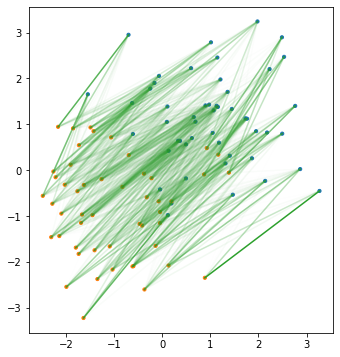

In [8]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=a*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=b*500)

# UOT penalization KL + H

In [9]:
u,v,G=sinkhorn(a,b,C,lam=20,lam2=20,eps=.3,pen="kl",numiter=100)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))
print(torch.sum(P*C))

tensor(0.8809)
tensor(5.2393)


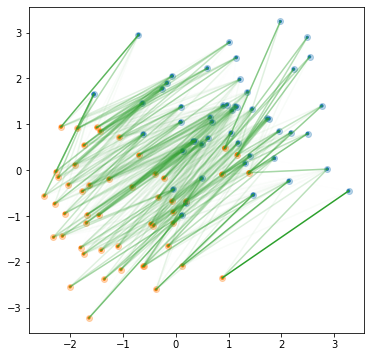

In [10]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# UOT penalization L2 + H

In [11]:
from scipy.special import lambertw

In [12]:
u,v,G=sinkhorn(a,b,C,lam=30,eps=.3,pen="l2")
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.1676)
tensor(0.5867)


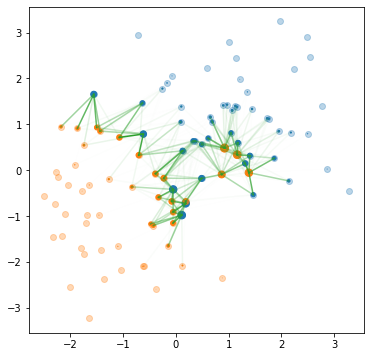

In [13]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# UOT penalization MMD + H

In [14]:
Kx,Ky=kernel(X,Y,sigma=10,k="gaussian")
u,v,G=sinkhorn(a,b,C,lam=10,lam2=None,eps=.5,pen="MMD",numiter=100,Kx=Kx,Ky=Ky,numiter2=10,lr=1e-4)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))
print(torch.sum(P*C))

tensor(0.8997)
tensor(0.4646)


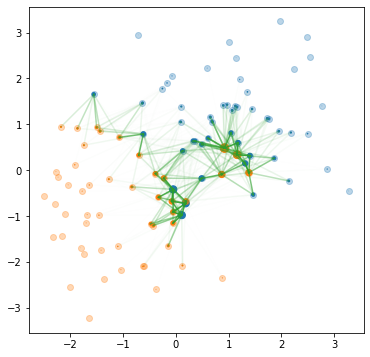

In [15]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# UOT penalization Sinkhorn + H

In [16]:
u,v,G,Qx,Qy=sinkhorn(a,b,ot.dist(X,Y),lam=1e1,eps=.7,numiter=30,pen="sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=10,innerplan=True)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.)
tensor(0.7993)


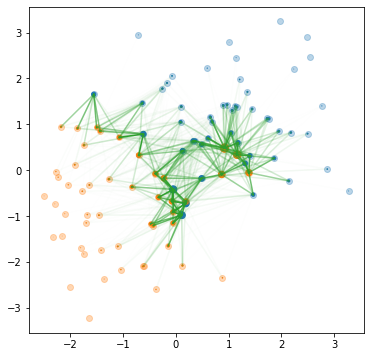

In [17]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
#ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
#ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

In [42]:
#Other Data set

n,d=5,2
#X,Y=make_data('mog_reg',n,d)
X,Y=make_data("gaussians",n,d)
C=ot.dist(X,Y)

a=torch.ones((n,))/n
b=torch.ones((n,))/n

In [69]:
u,v,G,Qx,Qy=sinkhorn(a,b,ot.dist(X,Y),lam=5e0,eps=1e0,numiter=100,pen="sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=10,innerplan=True)

P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.0000)
tensor(0.6801)


In [73]:
torch.sum(Qx,1)

tensor([0.0093, 0.5371, 0.2084, 0.0039, 0.2412])

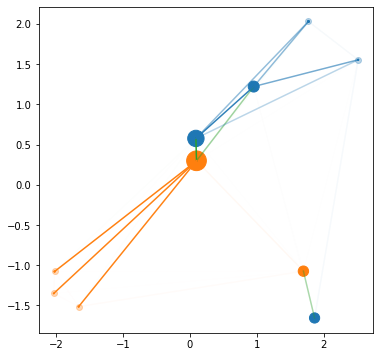

In [70]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# UOT penalization semi-relaxed + H

In [21]:
u,v,G,Qx,Qy=sinkhorn(a,b,ot.dist(X,Y),lam=10,eps=1,numiter=100,pen="UOT_sinkhorn_1iter",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),lam3=10,numiter2=10,innerplan=True)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))
print(torch.sum(P*C))

tensor(1.0712)
tensor(4.0004)


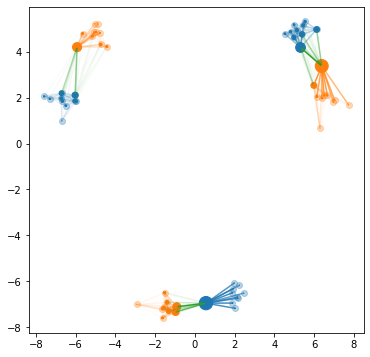

In [22]:
P/=torch.sum(P)
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)

# Log domain

In [23]:
u,v,G=logsinkhorn(a,b,C,lam=10,eps=.2,numiter=1000,lam2=None,pen="kl")
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
P.sum()

tensor(0.6287)

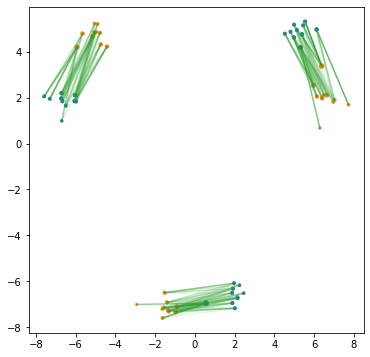

In [24]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)

In [25]:
u,v,G,Qx,Qy=logsinkhorn(a,b,ot.dist(X,Y),lam=1,eps=.5,numiter=100,pen="sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=20,innerplan=True)
P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
P.sum(),Qx.sum(),Qy.sum()

(tensor(1.), tensor(1.), tensor(1.0000))

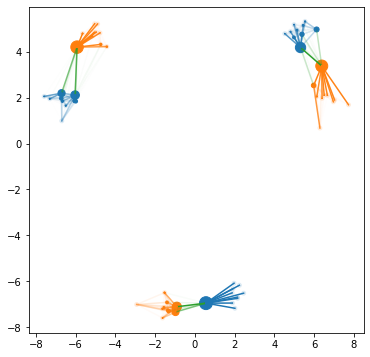

In [26]:
pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')#
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=a*500,alpha=.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=b*500,alpha=.1)

In [27]:
"""u,v,G,Qx,Qy=logsinkhorn(a,b,ot.dist(X,Y),lam=1e2,eps=5e0,numiter=50,pen="UOT_sinkhorn",
               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=50,innerplan=True,lam3=1)

P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
print(torch.sum(P))"""

'u,v,G,Qx,Qy=logsinkhorn(a,b,ot.dist(X,Y),lam=1e2,eps=5e0,numiter=50,pen="UOT_sinkhorn",\n               Cx=ot.dist(X,X),Cy=ot.dist(Y,Y),numiter2=50,innerplan=True,lam3=1)\n\nP=u.reshape((-1, 1)) * G * v.reshape((1, -1))\nprint(torch.sum(P))'

In [28]:
"""pl.figure(figsize=(6,6))
ot.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')
ot.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')
ot.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)"""

"pl.figure(figsize=(6,6))\not.plot.plot2D_samples_mat(X.numpy(), Y.numpy(), P.numpy(), c='C2')\not.plot.plot2D_samples_mat(X.numpy(), X.numpy(), Qx.numpy(), c='C0')\not.plot.plot2D_samples_mat(Y.numpy(), Y.numpy(), Qy.numpy(), c='C1')\npl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',s=torch.sum(P,axis=1)*500)\npl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',s=torch.sum(P,axis=0)*500)\npl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.3)\npl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.3)"